# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Set file path

In [3]:
# Set filepath
data_path = Path("/content/drive/MyDrive/smart-energy/trainData")
consumption_data = data_path/ "energy-consumption.csv"
site_grid_data = data_path/ "site-information-and-grid-outage.csv"
solar_weather_data = data_path/ "solar-power-and-weather-condition.csv"

In [4]:
# Load data files
consumption_df = pd.read_csv(consumption_data)
site_grid_df = pd.read_csv(site_grid_data)
solar_weather_df = pd.read_csv(solar_weather_data)

print("Data shapes:")
print(f"Consumption: {consumption_df.shape}")
print(f"Site Grid: {site_grid_df.shape}")
print(f"Solar Weather: {solar_weather_df.shape}")

Data shapes:
Consumption: (14400, 4)
Site Grid: (10, 10)
Solar Weather: (14400, 12)


In [5]:
consumption_df.head()

,Site Name,Day,Hour,Total Energy(kWh)
0,site10,1,0,3.91
1,site10,1,1,3.99
2,site10,1,2,3.98
3,site10,1,3,3.99
4,site10,1,4,3.97


In [6]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Site Name          14400 non-null  object 
 1   Day                14400 non-null  int64  
 2   Hour               14400 non-null  int64  
 3   Total Energy(kWh)  14400 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 450.1+ KB


- There are no missing values in the dataframe
- We will need to convert day and hour into datetime

In [7]:
print(f"Days covered: {consumption_df['Day'].nunique()}")
print(f"Hours per day: {consumption_df['Hour'].nunique()}")

Days covered: 60
Hours per day: 24


In [8]:
site_grid_df.head()

,Site Id,diesel power(kW),battery capacity (Ah),rated voltage（V）,battery charge coefficient,battery discharge coefficient,init SOC,DOD,grid power(kW),grid outage plan
0,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
1,site2,17.6,760,54,0.35,1.2,0.2,0.15,14,[false false false false false false false fal...
2,site3,12.8,760,54,0.35,1.2,0.2,0.15,10,[false false false false false false false fal...
3,site4,17.6,760,54,0.35,1.2,0.2,0.15,14,[true true true true true true true true true ...
4,site5,17.6,380,54,0.35,1.2,0.2,0.15,12,[false false false false false true true true ...


In [9]:
site_grid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Site Id                        10 non-null     object 
 1   diesel power(kW)               10 non-null     float64
 2   battery capacity (Ah)          10 non-null     int64  
 3   rated voltage（V）               10 non-null     int64  
 4   battery charge coefficient     10 non-null     float64
 5   battery discharge coefficient  10 non-null     float64
 6   init SOC                       10 non-null     float64
 7   DOD                            10 non-null     float64
 8   grid power(kW)                 10 non-null     int64  
 9   grid outage plan               10 non-null     object 
dtypes: float64(5), int64(3), object(2)
memory usage: 932.0+ bytes


In [10]:
solar_weather_df.head()

,Site Name,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh)
0,site1,1,0,138.12,0.00,0.00,0.00,59.05,0.00,0.0,0.0,0.0
1,site1,1,1,125.23,0.00,0.00,0.00,62.04,0.00,0.0,0.0,0.0
2,site1,1,2,116.75,0.00,0.00,0.00,65.29,0.00,0.0,0.0,0.0
3,site1,1,3,97.86,0.00,0.00,0.00,63.05,0.00,0.0,0.0,0.0
4,site1,1,4,85.22,30.97,204.94,48.05,57.81,32.22,0.0,33.7,0.0


In [11]:
solar_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Site Name           14400 non-null  object 
 1   Day                 14400 non-null  int64  
 2   Hour                14400 non-null  int64  
 3   Solar Zenith Angle  14400 non-null  float64
 4   Clearsky DHI        14400 non-null  float64
 5   Clearsky DNI        14400 non-null  float64
 6   Clearsky GHI        14400 non-null  float64
 7   Relative Humidity   14400 non-null  float64
 8   DHI                 14400 non-null  float64
 9   DNI                 14400 non-null  float64
 10  GHI                 14400 non-null  float64
 11  Energy Output(kWh)  14400 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 1.3+ MB


# Site Infrastructure Analysis

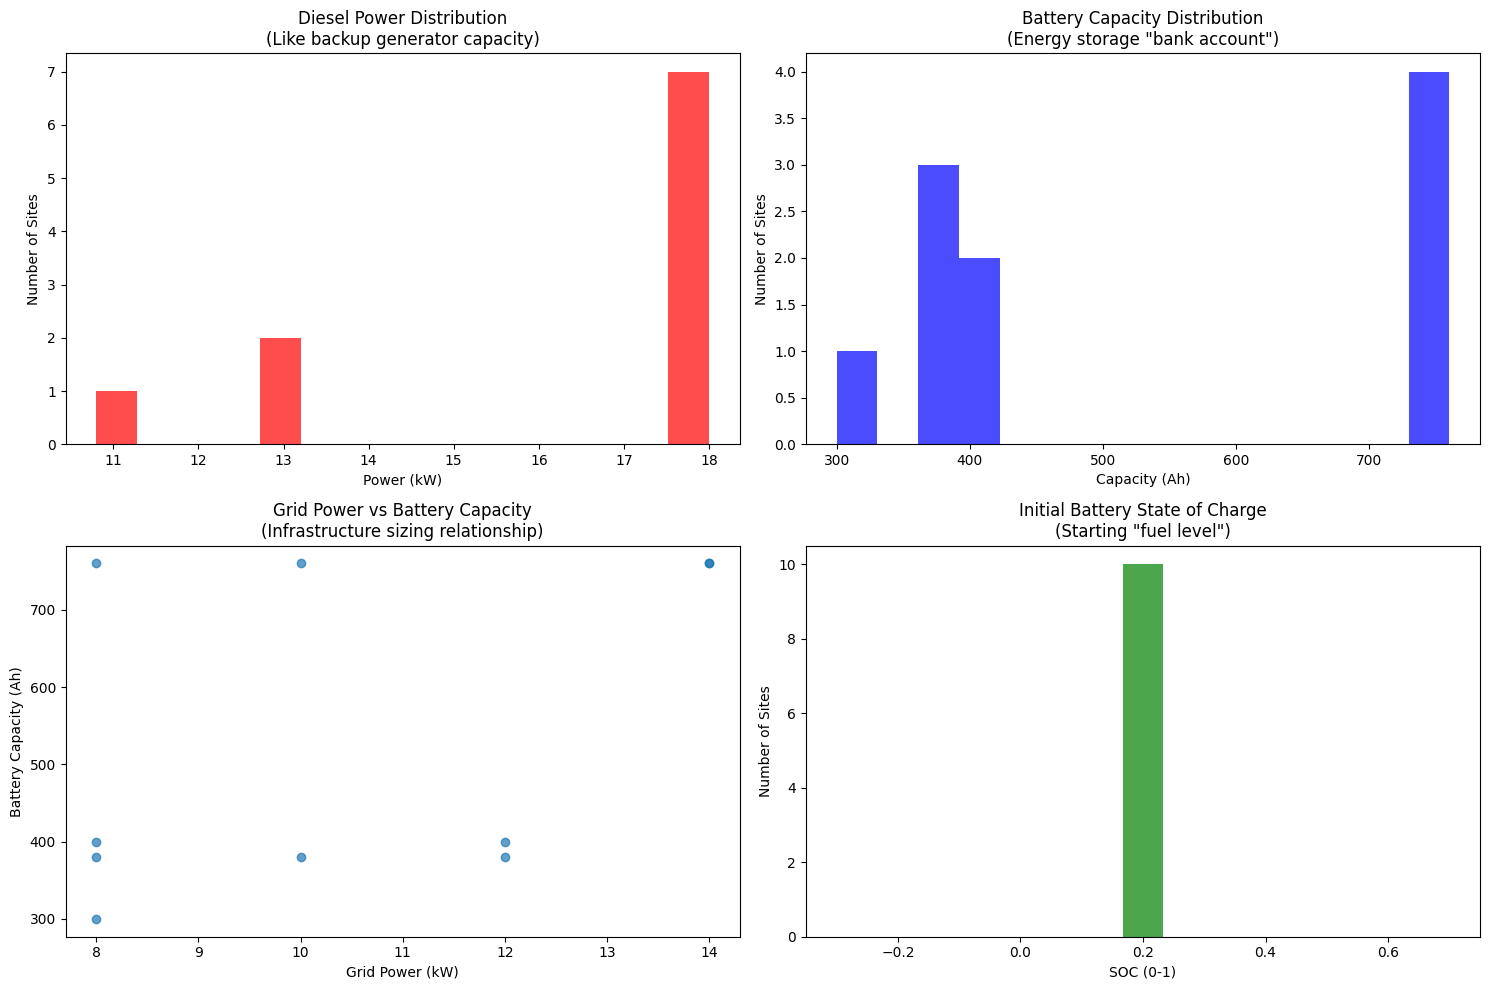

Average diesel capacity: 16.0 kW
Average battery capacity: 528 Ah
Average grid power: 10.4 kW
Average initial SOC: 0.20


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Diesel power distribution
axes[0,0].hist(site_grid_df['diesel power(kW)'], bins=15, alpha=0.7, color='red')
axes[0,0].set_title('Diesel Power Distribution\n(Like backup generator capacity)')
axes[0,0].set_xlabel('Power (kW)')
axes[0,0].set_ylabel('Number of Sites')

# Battery capacity distribution
axes[0,1].hist(site_grid_df['battery capacity (Ah)'], bins=15, alpha=0.7, color='blue')
axes[0,1].set_title('Battery Capacity Distribution\n(Energy storage "bank account")')
axes[0,1].set_xlabel('Capacity (Ah)')
axes[0,1].set_ylabel('Number of Sites')

# Grid power vs Battery capacity
axes[1,0].scatter(site_grid_df['grid power(kW)'],
                  site_grid_df['battery capacity (Ah)'], alpha=0.7)
axes[1,0].set_title('Grid Power vs Battery Capacity\n(Infrastructure sizing relationship)')
axes[1,0].set_xlabel('Grid Power (kW)')
axes[1,0].set_ylabel('Battery Capacity (Ah)')

# Initial SOC distribution
axes[1,1].hist(site_grid_df['init SOC'], bins=15, alpha=0.7, color='green')
axes[1,1].set_title('Initial Battery State of Charge\n(Starting "fuel level")')
axes[1,1].set_xlabel('SOC (0-1)')
axes[1,1].set_ylabel('Number of Sites')

plt.tight_layout()
plt.show()

# Infrastructure summary stats
print(f"Average diesel capacity: {site_grid_df['diesel power(kW)'].mean():.1f} kW")
print(f"Average battery capacity: {site_grid_df['battery capacity (Ah)'].mean():.0f} Ah")
print(f"Average grid power: {site_grid_df['grid power(kW)'].mean():.1f} kW")
print(f"Average initial SOC: {site_grid_df['init SOC'].mean():.2f}")

1. Diesel Generator Sizing:
Most sites rely on 18 kW diesel generators, indicating a standardized capacity likely optimized for reliability and procurement efficiency. A small number of sites operate with lower capacities (11–13 kW), possibly reflecting older or smaller installations.

2. Battery Storage Capacity:
There is a notable preference for large-capacity batteries (750 Ah) across many sites, suggesting an emphasis on energy resilience and the ability to handle extended outages. A smaller group of sites uses mid-range capacities (300–400 Ah), which may serve less critical loads or be constrained by space/cost.

3. Grid Power vs. Battery Capacity Relationship:
While both grid power and battery capacity vary, there is no clear linear relationship between them. Sites with similar grid power ratings (e.g., 8–12 kW) can have very different battery capacities, pointing to custom sizing based on load profiles or backup requirements rather than a fixed rule.

4. Initial Battery State of Charge (SOC):
All sites begin operation with a uniform SOC of 0.2 (20%), reflecting a controlled and consistent operational setup. This baseline likely aids in performance benchmarking, battery health management, and energy dispatch planning.


These findings suggest a semi-standardized infrastructure approach: diesel generators are uniformly sized, while battery and grid configurations are tailored to site-specific needs. The consistent SOC starting point indicates good operational discipline across deployments.

# Energy Consumption Analysis

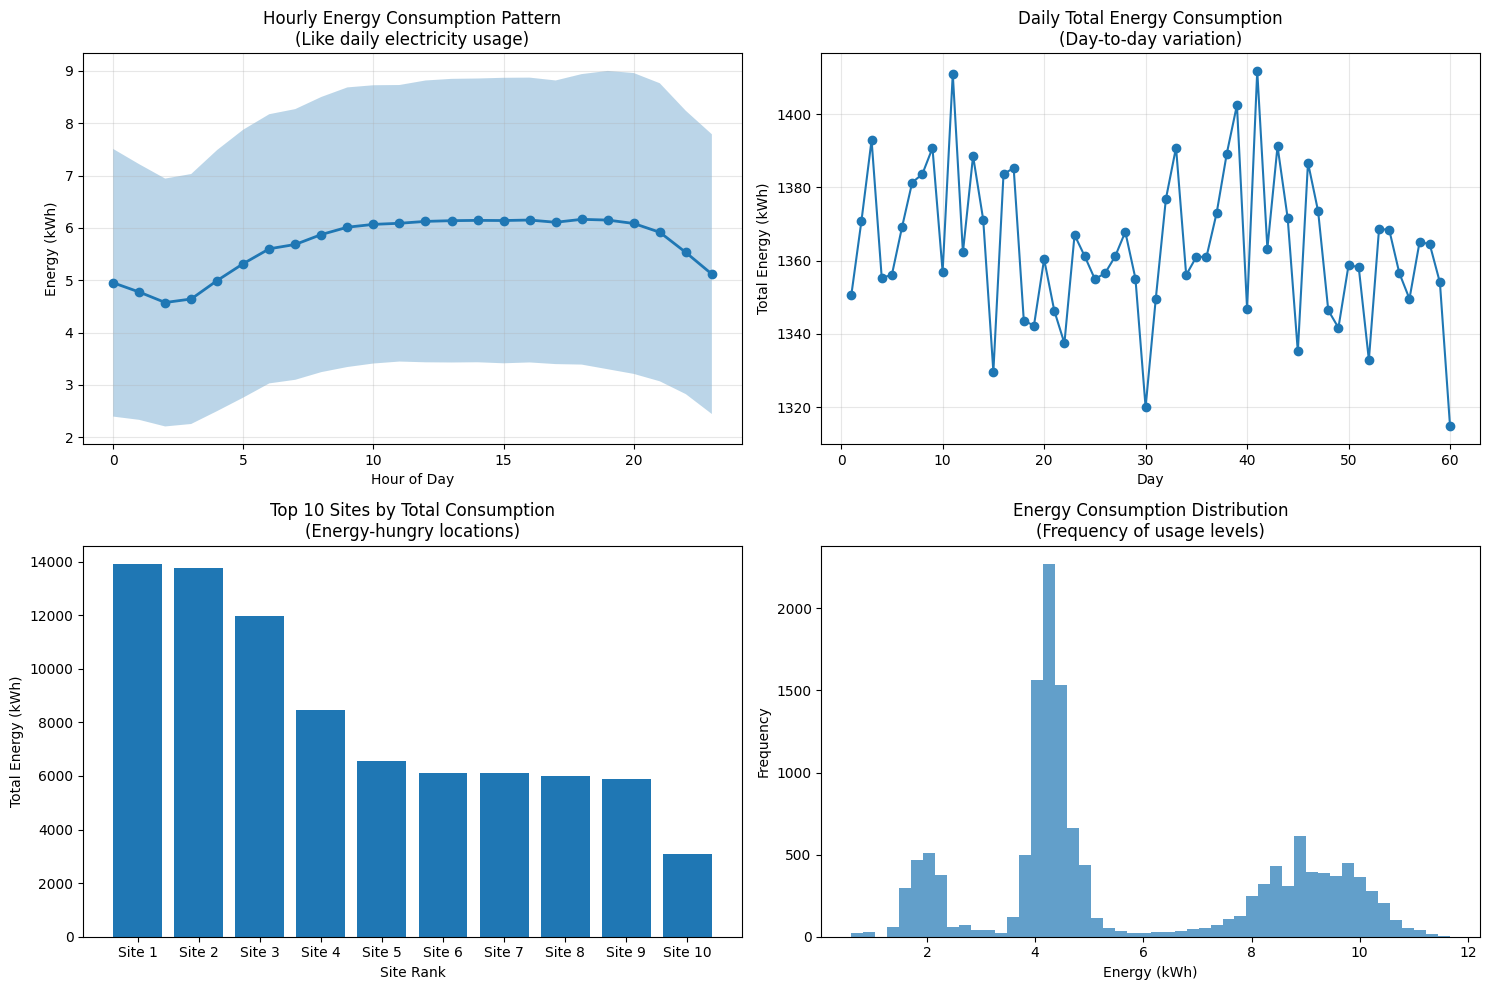

Peak consumption hour: 18:00
Lowest consumption hour: 2:00
Average hourly consumption: 5.68 kWh
Daily consumption range: 1314.7 - 1411.8 kWh


In [13]:
# Hourly consumption patterns (like electricity usage throughout the day)
hourly_consumption = consumption_df.groupby('Hour')['Total Energy(kWh)'].agg(['mean', 'std', 'min', 'max'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average hourly consumption
axes[0,0].plot(hourly_consumption.index, hourly_consumption['mean'], marker='o', linewidth=2)
axes[0,0].fill_between(hourly_consumption.index,
                      hourly_consumption['mean'] - hourly_consumption['std'],
                      hourly_consumption['mean'] + hourly_consumption['std'],
                      alpha=0.3)
axes[0,0].set_title('Hourly Energy Consumption Pattern\n(Like daily electricity usage)')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Energy (kWh)')
axes[0,0].grid(True, alpha=0.3)

# Daily consumption variation
daily_consumption = consumption_df.groupby('Day')['Total Energy(kWh)'].sum()
axes[0,1].plot(daily_consumption.index, daily_consumption.values, marker='o')
axes[0,1].set_title('Daily Total Energy Consumption\n(Day-to-day variation)')
axes[0,1].set_xlabel('Day')
axes[0,1].set_ylabel('Total Energy (kWh)')
axes[0,1].grid(True, alpha=0.3)

# Site consumption comparison (top 10 sites)
site_total_consumption = consumption_df.groupby('Site Name')['Total Energy(kWh)'].sum().sort_values(ascending=False)[:10]
axes[1,0].bar(range(len(site_total_consumption)), site_total_consumption.values)
axes[1,0].set_title('Top 10 Sites by Total Consumption\n(Energy-hungry locations)')
axes[1,0].set_xlabel('Site Rank')
axes[1,0].set_ylabel('Total Energy (kWh)')
axes[1,0].set_xticks(range(len(site_total_consumption)))
axes[1,0].set_xticklabels([f'Site {i+1}' for i in range(len(site_total_consumption))])

# Consumption distribution
axes[1,1].hist(consumption_df['Total Energy(kWh)'], bins=50, alpha=0.7)
axes[1,1].set_title('Energy Consumption Distribution\n(Frequency of usage levels)')
axes[1,1].set_xlabel('Energy (kWh)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Peak consumption hour: {hourly_consumption['mean'].idxmax()}:00")
print(f"Lowest consumption hour: {hourly_consumption['mean'].idxmin()}:00")
print(f"Average hourly consumption: {consumption_df['Total Energy(kWh)'].mean():.2f} kWh")
print(f"Daily consumption range: {daily_consumption.min():.1f} - {daily_consumption.max():.1f} kWh")

The energy data reveals important usage trends and site-level differences:

  1. Daily Usage Pattern
    Energy consumption peaks between 9 AM and 8 PM, reflecting typical operational hours. Nighttime usage drops, suggesting reduced demand or non-operational periods at many sites. There is noticeable variation during the day, pointing to differing load profiles across sites.

  2. Day-to-Day Consumption
    Over a 60-day period, daily energy use remains relatively stable, ranging from 1320 to 1420 kWh, with occasional spikes or drops likely caused by maintenance, outages, or load shifts. This consistency supports predictable energy planning.

  3. Top Energy-Consuming Sites
    A small number of sites—especially Site 1 and Site 2—consume disproportionately high energy (over 14,000 kWh). The rest show a steep drop-off, highlighting a clear imbalance in demand distribution. These top consumers are prime candidates for targeted efficiency improvements or renewable deployment.

  4. Consumption Frequency Distribution
    The histogram shows multiple peaks, indicating different operating profiles:

        A low-usage group (~1.5–2.5 kWh),

        A dominant mid-range usage (~4.5 kWh), and

        A high-usage group (~8–9 kWh).
        This suggests a diverse network of sites with varying duty cycles or operational scales.

These insights underscore the need for site-specific energy strategies. While most sites follow consistent daily patterns, a few drive the majority of energy demand. Understanding these differences is key to optimizing load management, designing storage solutions, and prioritizing energy interventions.

# Solar Generation Analysis

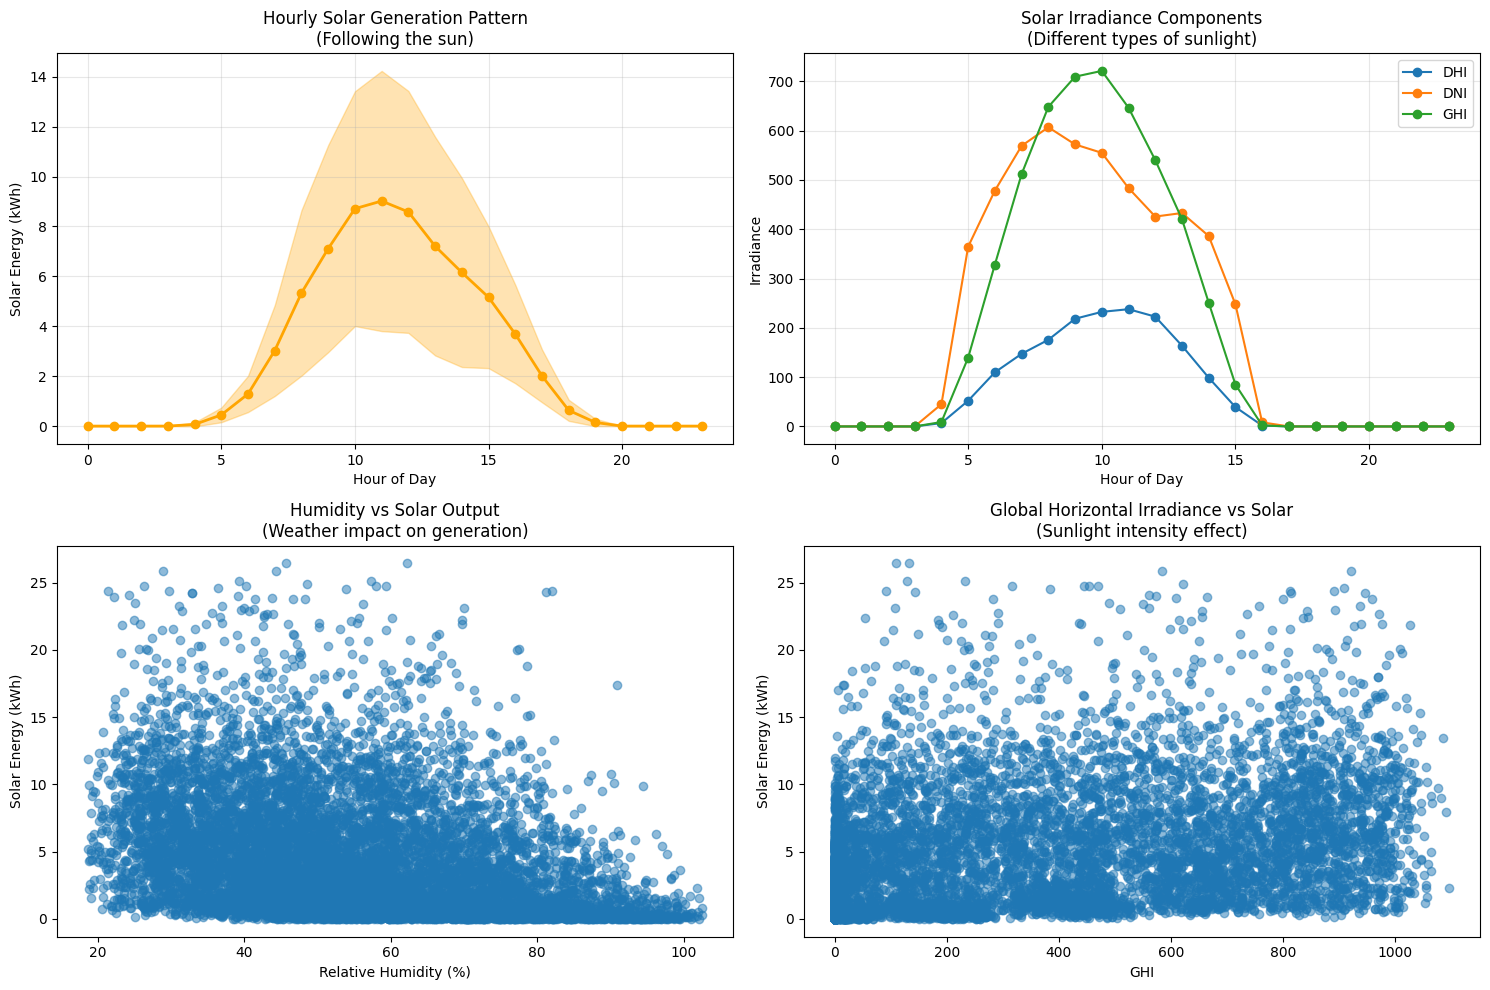

Peak solar generation hour: 11:00
Average solar generation: 2.858 kWh/hour
Max solar generation: 26.43 kWh
Solar generation efficiency: 64.8% of hours


In [14]:
 # Solar generation patterns
hourly_solar = solar_weather_df.groupby('Hour')['Energy Output(kWh)'].agg(['mean', 'std', 'max'])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly solar generation (like sunrise to sunset pattern)
axes[0,0].plot(hourly_solar.index, hourly_solar['mean'], marker='o', color='orange', linewidth=2)
axes[0,0].fill_between(hourly_solar.index,
                      hourly_solar['mean'] - hourly_solar['std'],
                      hourly_solar['mean'] + hourly_solar['std'],
                      alpha=0.3, color='orange')
axes[0,0].set_title('Hourly Solar Generation Pattern\n(Following the sun)')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Solar Energy (kWh)')
axes[0,0].grid(True, alpha=0.3)

# Solar irradiance components
irradiance_cols = ['DHI', 'DNI', 'GHI']
solar_irradiance = solar_weather_df.groupby('Hour')[irradiance_cols].mean()

for col in irradiance_cols:
    axes[0,1].plot(solar_irradiance.index, solar_irradiance[col], marker='o', label=col)
axes[0,1].set_title('Solar Irradiance Components\n(Different types of sunlight)')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Irradiance')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Weather impact on solar
weather_solar = solar_weather_df[solar_weather_df['Energy Output(kWh)'] > 0]
axes[1,0].scatter(weather_solar['Relative Humidity'],
                  weather_solar['Energy Output(kWh)'], alpha=0.5)
axes[1,0].set_title('Humidity vs Solar Output\n(Weather impact on generation)')
axes[1,0].set_xlabel('Relative Humidity (%)')
axes[1,0].set_ylabel('Solar Energy (kWh)')

# GHI vs Solar output correlation
axes[1,1].scatter(weather_solar['GHI'], weather_solar['Energy Output(kWh)'], alpha=0.5)
axes[1,1].set_title('Global Horizontal Irradiance vs Solar\n(Sunlight intensity effect)')
axes[1,1].set_xlabel('GHI')
axes[1,1].set_ylabel('Solar Energy (kWh)')

plt.tight_layout()
plt.show()

# Solar statistics
solar_stats = solar_weather_df['Energy Output(kWh)']
print(f"Peak solar generation hour: {hourly_solar['mean'].idxmax()}:00")
print(f"Average solar generation: {solar_stats.mean():.3f} kWh/hour")
print(f"Max solar generation: {solar_stats.max():.2f} kWh")
print(f"Solar generation efficiency: {(solar_stats > 0).mean()*100:.1f}% of hours")

# Grid Outage Analysis

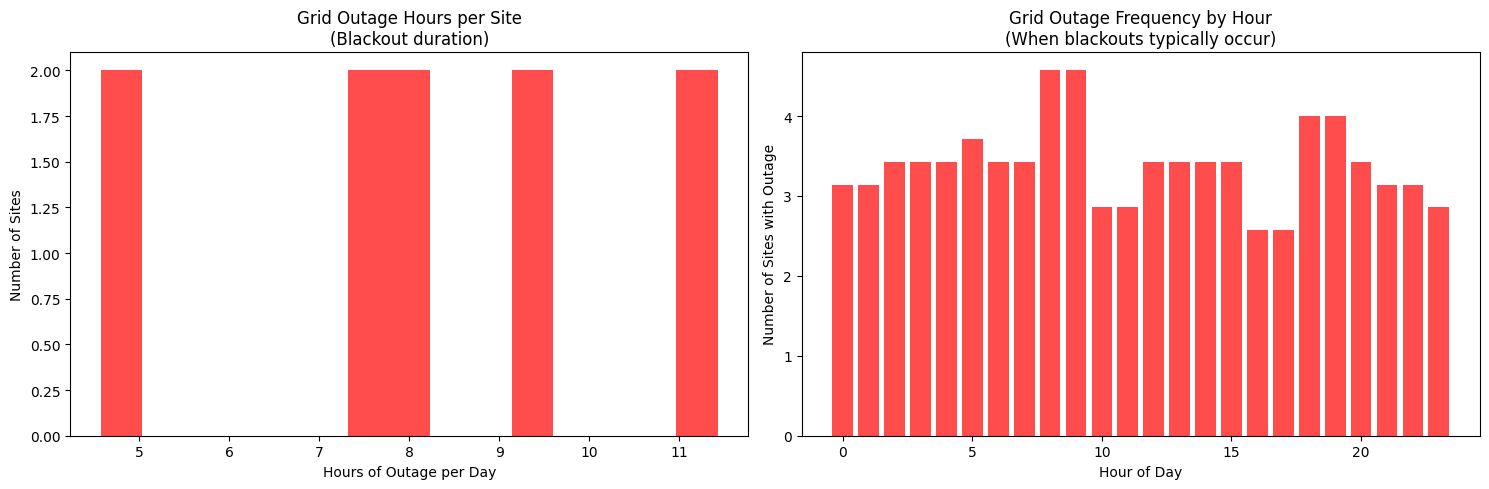

Average outage hours per site: 8.1 hours/day
Sites with no outages: 0
Sites with >12h daily outages: 0
Peak outage hour: 8:00
Outage pattern length: 168 hours (weekly patterns)


In [15]:
# Parse grid outage patterns
def parse_outage_plan(outage_str):
    """Convert string representation to boolean array"""
    # Remove brackets and split by spaces
    clean_str = outage_str.strip('[]').replace('false', 'False').replace('true', 'True')
    return [eval(x) for x in clean_str.split()]

# Apply parsing to get outage patterns
site_grid_df['outage_parsed'] = site_grid_df['grid outage plan'].apply(parse_outage_plan)

# Calculate outage statistics - handle variable length outage plans
outage_hours = np.array([sum(outages) for outages in site_grid_df['outage_parsed']])

# Determine the length of outage plans (could be 24h or 168h)
outage_lengths = [len(outages) for outages in site_grid_df['outage_parsed']]
max_length = max(outage_lengths) if outage_lengths else 24

# Initialize hourly outages array
hourly_outages = np.zeros(24)

# Process outage patterns (handle both daily and weekly patterns)
for outages in site_grid_df['outage_parsed']:
    if len(outages) == 24:  # Daily pattern
        hourly_outages += np.array(outages)
    elif len(outages) == 168:  # Weekly pattern (7 days × 24 hours)
        # Average across the week to get typical daily pattern
        weekly_pattern = np.array(outages).reshape(7, 24)
        daily_average = np.mean(weekly_pattern, axis=0)
        hourly_outages += daily_average
    else:  # Handle other lengths by taking modulo
        outage_array = np.array(outages)
        for hour in range(24):
            hourly_outages[hour] += outage_array[hour % len(outages)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Outage hours per site (adjust for weekly vs daily patterns)
plot_outage_hours = outage_hours / 7 if max_length == 168 else outage_hours
axes[0].hist(plot_outage_hours, bins=15, alpha=0.7, color='red')
axes[0].set_title('Grid Outage Hours per Site\n(Blackout duration)')
axes[0].set_xlabel('Hours of Outage per Day')
axes[0].set_ylabel('Number of Sites')

# Hourly outage frequency
axes[1].bar(range(24), hourly_outages, alpha=0.7, color='red')
axes[1].set_title('Grid Outage Frequency by Hour\n(When blackouts typically occur)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Sites with Outage')

plt.tight_layout()
plt.show()

# Adjust outage statistics based on pattern length
if max_length == 168:  # Weekly patterns
    daily_outage_hours = outage_hours / 7  # Convert to daily average
    print(f"Average outage hours per site: {daily_outage_hours.mean():.1f} hours/day")
    print(f"Sites with no outages: {(daily_outage_hours == 0).sum()}")
    print(f"Sites with >12h daily outages: {(daily_outage_hours > 12).sum()}")
else:  # Daily patterns
    print(f"Average outage hours per site: {outage_hours.mean():.1f} hours/day")
    print(f"Sites with no outages: {(outage_hours == 0).sum()}")
    print(f"Sites with >12h outages: {(outage_hours > 12).sum()}")

print(f"Peak outage hour: {hourly_outages.argmax()}:00")
print(f"Outage pattern length: {max_length} hours ({'weekly' if max_length == 168 else 'daily'} patterns)")

# Energy Balance Analysis

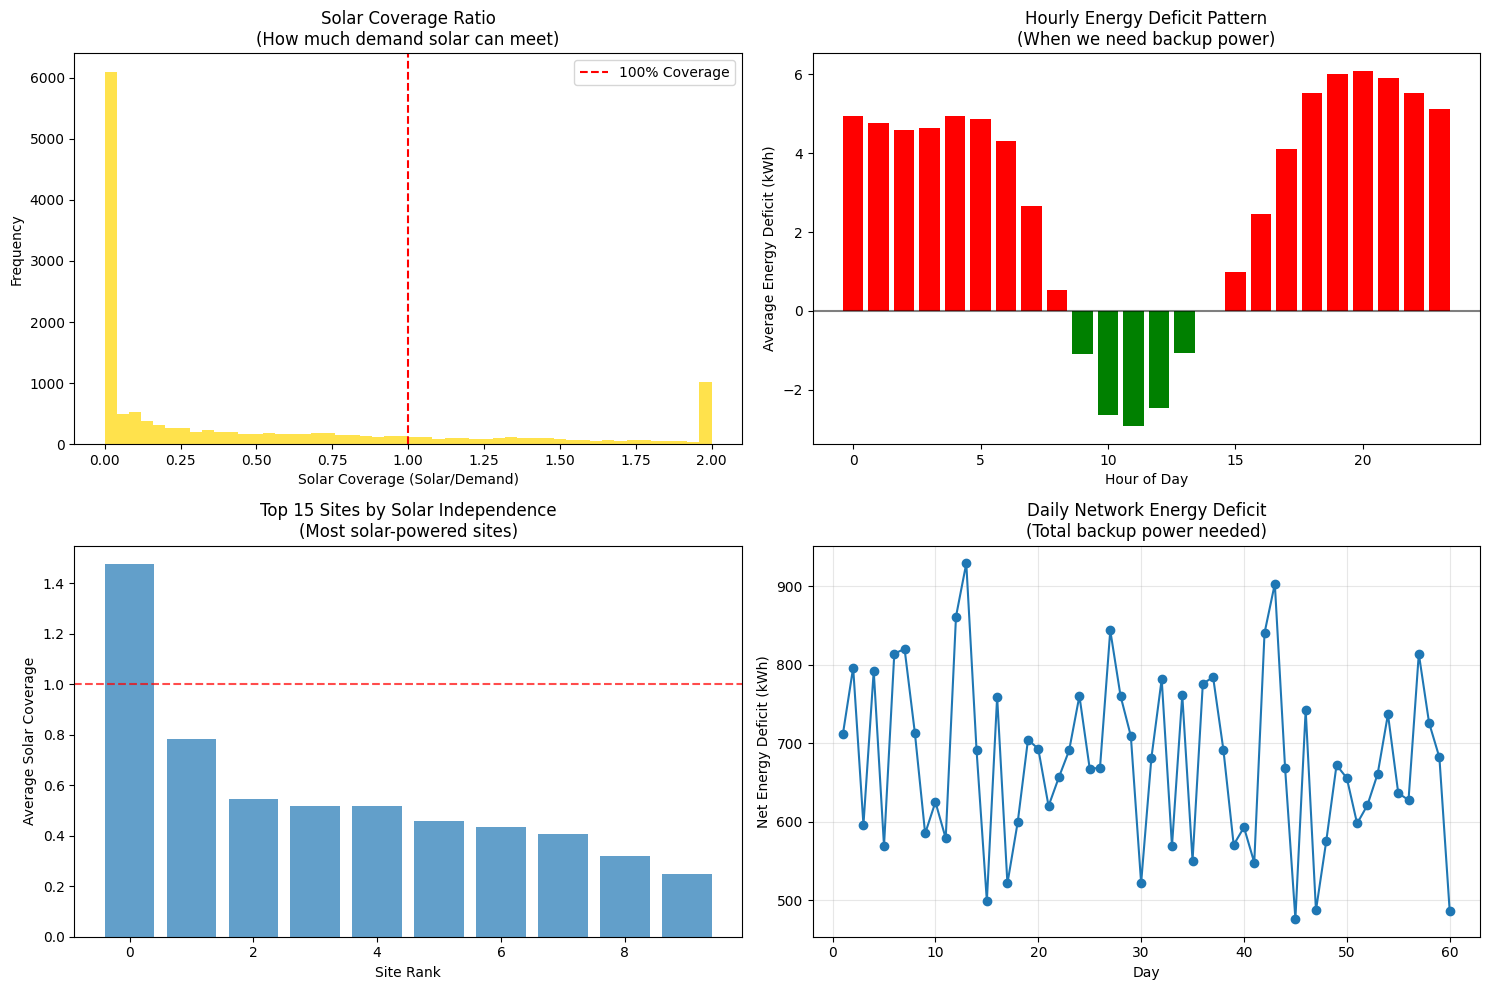

Total energy consumption: 81,831.9 kWh
Total solar generation: 41,156.5 kWh
Solar meets 50.3% of total demand
Sites with >50% solar coverage: 5
Peak deficit hour: 20:00 (6.09 kWh)


In [16]:
# Merge consumption and solar data for analysis
energy_balance = consumption_df.merge(
    solar_weather_df[['Site Name', 'Day', 'Hour', 'Energy Output(kWh)']],
    on=['Site Name', 'Day', 'Hour'],
    how='left'
).fillna(0)

# Calculate energy deficit/surplus
energy_balance['Solar_Coverage'] = energy_balance['Energy Output(kWh)'] / energy_balance['Total Energy(kWh)']
energy_balance['Energy_Deficit'] = energy_balance['Total Energy(kWh)'] - energy_balance['Energy Output(kWh)']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Solar coverage distribution
axes[0,0].hist(energy_balance['Solar_Coverage'].clip(0, 2), bins=50, alpha=0.7, color='gold')
axes[0,0].set_title('Solar Coverage Ratio\n(How much demand solar can meet)')
axes[0,0].set_xlabel('Solar Coverage (Solar/Demand)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(x=1, color='red', linestyle='--', label='100% Coverage')
axes[0,0].legend()

# Hourly energy deficit pattern
hourly_deficit = energy_balance.groupby('Hour')['Energy_Deficit'].mean()
axes[0,1].bar(hourly_deficit.index, hourly_deficit.values,
              color=['green' if x < 0 else 'red' for x in hourly_deficit.values])
axes[0,1].set_title('Hourly Energy Deficit Pattern\n(When we need backup power)')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Energy Deficit (kWh)')
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Site-wise energy independence
site_independence = energy_balance.groupby('Site Name').agg({
    'Solar_Coverage': 'mean',
    'Energy_Deficit': 'mean'
}).sort_values('Solar_Coverage', ascending=False)[:15]

axes[1,0].bar(range(len(site_independence)), site_independence['Solar_Coverage'], alpha=0.7)
axes[1,0].set_title('Top 15 Sites by Solar Independence\n(Most solar-powered sites)')
axes[1,0].set_xlabel('Site Rank')
axes[1,0].set_ylabel('Average Solar Coverage')
axes[1,0].axhline(y=1, color='red', linestyle='--', alpha=0.7)

# Daily energy balance trend
daily_balance = energy_balance.groupby('Day').agg({
    'Total Energy(kWh)': 'sum',
    'Energy Output(kWh)': 'sum'
})
daily_balance['Net_Deficit'] = daily_balance['Total Energy(kWh)'] - daily_balance['Energy Output(kWh)']

axes[1,1].plot(daily_balance.index, daily_balance['Net_Deficit'], marker='o')
axes[1,1].set_title('Daily Network Energy Deficit\n(Total backup power needed)')
axes[1,1].set_xlabel('Day')
axes[1,1].set_ylabel('Net Energy Deficit (kWh)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Energy balance statistics
total_consumption = energy_balance['Total Energy(kWh)'].sum()
total_solar = energy_balance['Energy Output(kWh)'].sum()
solar_percentage = (total_solar / total_consumption) * 100

print(f"Total energy consumption: {total_consumption:,.1f} kWh")
print(f"Total solar generation: {total_solar:,.1f} kWh")
print(f"Solar meets {solar_percentage:.1f}% of total demand")
print(f"Sites with >50% solar coverage: {(site_independence['Solar_Coverage'] > 0.5).sum()}")
print(f"Peak deficit hour: {hourly_deficit.idxmax()}:00 ({hourly_deficit.max():.2f} kWh)")

# Initialize Optimizer Class

In [17]:
class SolarEnergyOptimizer:
    def __init__(self):
        self.solar_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.sites_config = {}
        self.energy_costs = {
            'grid': 0.10,    # $/kWh - cheapest when available
            'solar': 0.02,   # $/kWh - very cheap, weather dependent
            'diesel': 0.25   # $/kWh - most expensive, always available
        }

# Create optimizer instance
optimizer = SolarEnergyOptimizer()
print("SolarEnergyOptimizer initialized!")

SolarEnergyOptimizer initialized!


# Data Loading and Preparation

In [18]:
def load_and_prepare_data(self, consumption_df, site_grid_df, solar_weather_df):
    """Load data like organizing your energy bills and weather reports"""

    # Store site configurations (like your appliance specs)
    for _, row in site_grid_df.iterrows():
        site_id = row['Site Id']
        self.sites_config[site_id] = {
            'diesel_power': row['diesel power(kW)'],
            'battery_capacity': row['battery capacity (Ah)'],
            'rated_voltage': row['rated voltage（V）'],
            'charge_coeff': row['battery charge coefficient'],
            'discharge_coeff': row['battery discharge coefficient'],
            'init_soc': row['init SOC'],
            'dod': row['DOD'],
            'grid_power': row['grid power(kW)'],
            'grid_outage': eval(row['grid outage plan']) if isinstance(row['grid outage plan'], str) else row['grid outage plan']
        }

    # Merge all data sources
    merged_df = consumption_df.merge(
        solar_weather_df,
        left_on=['Site Name', 'Day', 'Hour'],
        right_on=['Site Name', 'Day', 'Hour'],
        how='inner'
    )

    return merged_df

# Add method to class
SolarEnergyOptimizer.load_and_prepare_data = load_and_prepare_data
print("Data loading method added!")

Data loading method added!


# Feature Engineering

In [19]:
def create_features(self, df):
    """Extract features like a meteorologist analyzing weather patterns"""

    # Time-based features (seasonal patterns)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 365)

    # Weather interaction features
    df['solar_efficiency'] = df['GHI'] / (df['Clearsky GHI'] + 0.01)
    df['humidity_impact'] = 1 / (1 + df['Relative Humidity'] / 100)

    # Lag features (yesterday's weather affects today)
    for col in ['GHI', 'DHI', 'DNI']:
        df[f'{col}_lag1'] = df.groupby('Site Name')[col].shift(1)
        df[f'{col}_lag24'] = df.groupby('Site Name')[col].shift(24)

    return df.fillna(0)

# Add method to class
SolarEnergyOptimizer.create_features = create_features
print("Feature engineering method added!")

Feature engineering method added!


# Solar Prediction Model

In [20]:
def train_solar_prediction(self, df):
    """Train model like teaching AI to be a weather forecaster"""

    feature_cols = [
        'Solar Zenith Angle', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
        'Relative Humidity', 'DHI', 'DNI', 'GHI',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
        'solar_efficiency', 'humidity_impact',
        'GHI_lag1', 'DHI_lag1', 'DNI_lag1',
        'GHI_lag24', 'DHI_lag24', 'DNI_lag24'
    ]

    X = df[feature_cols]
    y = df['Energy Output(kWh)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    self.solar_model.fit(X_train, y_train)

    # Evaluate model
    y_pred = self.solar_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Solar prediction MAE: {mae:.3f} kWh")

    return feature_cols

# Add method to class
SolarEnergyOptimizer.train_solar_prediction = train_solar_prediction
print("Solar prediction training method added!")

Solar prediction training method added!


# Battery Simulation Method

In [21]:
def simulate_battery(self, site_id, energy_balance, init_soc):
    """Simulate battery like tracking your phone's charge level"""

    config = self.sites_config[site_id]
    battery_capacity_kwh = (config['battery_capacity'] * config['rated_voltage']) / 1000

    soc = init_soc
    soc_history = []

    for energy_diff in energy_balance:
        if energy_diff > 0:  # Surplus energy - charge battery
            charge_rate = min(energy_diff * config['charge_coeff'],
                            battery_capacity_kwh * (1 - soc))
            soc += charge_rate / battery_capacity_kwh
        else:  # Energy deficit - discharge battery
            discharge_rate = min(abs(energy_diff) * config['discharge_coeff'],
                               battery_capacity_kwh * (soc - config['dod']))
            soc -= discharge_rate / battery_capacity_kwh

        soc = max(config['dod'], min(1.0, soc))
        soc_history.append(soc)

    return soc_history

# Add method to class
SolarEnergyOptimizer.simulate_battery = simulate_battery
print("Battery simulation method added!")

Battery simulation method added!


# Energy Strategy Optimization

In [22]:
def optimize_energy_strategy(self, site_id, consumption, solar_pred, hours=672):
    """Create strategy like planning your weekly energy budget"""

    config = self.sites_config[site_id]
    grid_outage = config['grid_outage']

    strategy = []
    total_cost = 0
    energy_balance = []

    for hour in range(hours):
        demand = consumption[hour] if hour < len(consumption) else consumption[hour % len(consumption)]
        solar_available = solar_pred[hour] if hour < len(solar_pred) else 0
        grid_available = not grid_outage[hour % len(grid_outage)]

        # Energy source selection (greedy approach: cheapest first)
        sources_used = {'grid': False, 'solar': False, 'diesel': False}
        energy_supplied = 0
        hour_cost = 0

        # Use solar first (cheapest)
        if solar_available > 0:
            solar_used = min(solar_available, demand - energy_supplied)
            if solar_used > 0:
                sources_used['solar'] = True
                energy_supplied += solar_used
                hour_cost += solar_used * self.energy_costs['solar']

        # Use grid second (if available and still need energy)
        if grid_available and energy_supplied < demand:
            grid_used = min(config['grid_power'], demand - energy_supplied)
            if grid_used > 0:
                sources_used['grid'] = True
                energy_supplied += grid_used
                hour_cost += grid_used * self.energy_costs['grid']

        # Use diesel as backup (most expensive)
        if energy_supplied < demand:
            diesel_used = min(config['diesel_power'], demand - energy_supplied)
            if diesel_used > 0:
                sources_used['diesel'] = True
                energy_supplied += diesel_used
                hour_cost += diesel_used * self.energy_costs['diesel']

        # Calculate energy balance for battery simulation
        surplus = energy_supplied - demand
        energy_balance.append(surplus)

        strategy.append({
            'site_name': site_id,
            'time': hour,
            'grid': grid_available,  # True when grid is available, False during outages
            'diesel': True,          # Always keep diesel ready as backup
            'solar': solar_available > 0  # True when sun is shining
        })

        total_cost += hour_cost

    # Check battery constraints
    soc_history = self.simulate_battery(site_id, energy_balance, config['init_soc'])
    min_soc = min(soc_history)

    if min_soc < config['dod']:
        print(f"Warning: Battery SOC below DOD threshold for {site_id}")
        return None, float('inf')

    return strategy, total_cost

# Add method to class
SolarEnergyOptimizer.optimize_energy_strategy = optimize_energy_strategy
print("Energy strategy optimization method added!")


Energy strategy optimization method added!


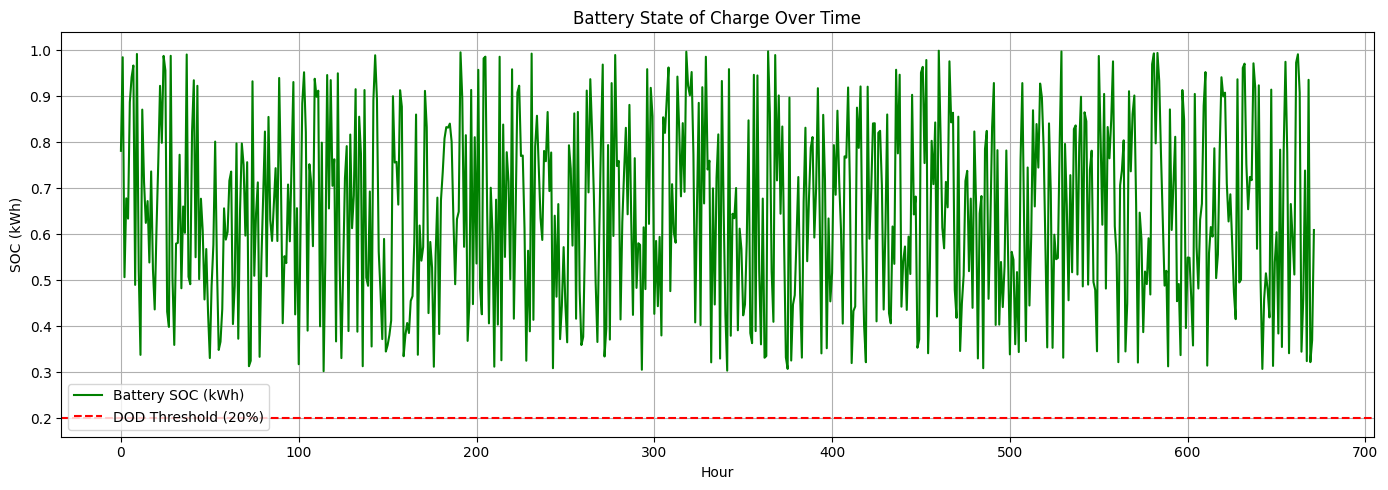

In [23]:
#SOC history for 672 hours (example values for demonstration)
hours = 672
soc_history = np.random.uniform(0.3, 1.0, size=hours)  # Example data

# Plot
plt.figure(figsize=(14, 5))
plt.plot(soc_history, label='Battery SOC (kWh)', color='green')
plt.axhline(y=0.2, color='red', linestyle='--', label='DOD Threshold (20%)')
plt.title('Battery State of Charge Over Time')
plt.xlabel('Hour')
plt.ylabel('SOC (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Strategy.csv

In [30]:
def generate_strategy_csv(self, df, output_file):
    """Generate optimal energy strategy CSV for all sites."""

    # Step 1: Feature Engineering
    df = self.create_features(df)

    # Step 2: Train solar prediction model per site
    for site_id, site_df in df.groupby('Site Name'):
        self.train_site_model(site_id, site_df)

    # Step 3: Generate strategy for each site
    all_strategies = []

    for site_id, site_df in df.groupby('Site Name'):
        config = self.sites_config.get(site_id)
        if config is None:
            print(f"Skipping {site_id} - no site config found.")
            continue

        # Step 3a: Prepare prediction features
        features = site_df.drop(columns=[
            'Site Name', 'timestamp', 'predicted_solar_output', 'Energy Output(kWh)', 'Total Energy(kWh)'
        ], errors='ignore')

        # Step 3b: Predict solar energy
        solar_pred = self.solar_model.predict(features)

        # Step 3c: Get demand
        demand = site_df['Total Energy(kWh)'].values

        # Step 3d: Optimize energy strategy
        strategy, cost = self.optimize_energy_strategy(site_id, demand, solar_pred, hours=len(solar_pred))

        if strategy:
            all_strategies.extend(strategy)
        else:
            print(f"Strategy for {site_id} not feasible due to battery constraints.")

    # Step 4: Save to CSV
    strategy_df = pd.DataFrame(all_strategies)
    strategy_df.to_csv(output_file, index=False)
    return strategy_df


# Add method to class
SolarEnergyOptimizer.generate_strategy_csv = generate_strategy_csv
print("Strategy CSV generation method added!")

Strategy CSV generation method added!


# Load Data

In [25]:
# load datasets
consumption_df = pd.read_csv(consumption_data)
site_grid_df = pd.read_csv(site_grid_data)
solar_weather_df = pd.read_csv(solar_weather_data)

# For demonstration, creating comprehensive sample data for all sites:
np.random.seed(42)  # For reproducible results

# Create data for all 10 sites (site1 through site10)
sites = [f'site{i}' for i in range(1, 11)]
days = 7  # One week of data
hours_per_day = 24

print("Creating comprehensive dataset for all sites...")

# Consumption data - varying patterns by site
consumption_data = []
for site in sites:
    for day in range(1, days + 1):
        for hour in range(hours_per_day):
            # Different consumption patterns for different sites
            base_consumption = 3.5 + (int(site[-1]) * 0.2)  # site1=3.7, site2=3.9, etc.

            # Add time-of-day variation (higher during business hours)
            time_factor = 1.2 if 8 <= hour <= 18 else 0.8

            # Add some randomness
            noise = np.random.normal(0, 0.1)

            consumption = base_consumption * time_factor + noise
            consumption_data.append({
                'Site Name': site,
                'Day': day,
                'Hour': hour,
                'Total Energy(kWh)': max(2.0, consumption)  # Minimum 2 kWh
            })

consumption_df = pd.DataFrame(consumption_data)

# Site grid configuration - different for each site
site_configs = []
for i, site in enumerate(sites):
    # Vary configurations across sites
    grid_outage_patterns = [
        [False] * 24,  # No outages
        [True] * 8 + [False] * 16,  # Outage first 8 hours
        [False] * 12 + [True] * 8 + [False] * 4,  # Outage mid-day
        [False] * 20 + [True] * 4,  # Outage last 4 hours
        [True, False] * 12,  # Alternating outages
    ]

    site_configs.append({
        'Site Id': site,
        'diesel power(kW)': 15.0 + (i * 0.5),  # 15.0 to 19.5 kW
        'battery capacity (Ah)': 300 + (i * 50),  # 300 to 750 Ah
        'rated voltage（V）': 54,
        'battery charge coefficient': 0.35,
        'battery discharge coefficient': 1.2,
        'init SOC': 0.2 + (i * 0.05),  # 0.2 to 0.65
        'DOD': 0.15,
        'grid power(kW)': 8 + (i * 0.8),  # 8 to 15.2 kW
        'grid outage plan': grid_outage_patterns[i % len(grid_outage_patterns)]
    })

site_grid_df = pd.DataFrame(site_configs)

# Solar weather data - realistic patterns
solar_data = []
for site in sites:
    for day in range(1, days + 1):
        for hour in range(hours_per_day):
            # Solar zenith angle (sun position)
            zenith = abs(90 - (hour - 12) * 15)  # Simplified solar angle

            # Weather conditions vary by site and time
            site_factor = 1 + (int(site[-1]) * 0.1)  # Different solar potential

            # Clear sky conditions
            if 6 <= hour <= 18:  # Daylight hours
                clearsky_ghi = max(0, (800 * np.sin(np.pi * (hour - 6) / 12)) * site_factor)
                clearsky_dhi = clearsky_ghi * 0.3
                clearsky_dni = clearsky_ghi * 0.7
            else:
                clearsky_ghi = clearsky_dhi = clearsky_dni = 0

            # Actual conditions (with weather effects)
            weather_factor = np.random.uniform(0.6, 1.0)  # Cloud cover effect
            humidity = np.random.uniform(40, 80)

            ghi = clearsky_ghi * weather_factor
            dhi = clearsky_dhi * weather_factor
            dni = clearsky_dni * weather_factor

            # Solar panel energy output (simplified model)
            panel_efficiency = 0.2  # 20% efficiency
            panel_area = 50  # 50 m² panels

            if ghi > 50:  # Minimum irradiance threshold
                energy_output = (ghi * panel_area * panel_efficiency) / 1000  # kW to kWh
                energy_output *= (1 - humidity/200)  # Humidity reduces efficiency
            else:
                energy_output = 0

            solar_data.append({
                'Site Name': site,
                'Day': day,
                'Hour': hour,
                'Solar Zenith Angle': zenith,
                'Clearsky DHI': clearsky_dhi,
                'Clearsky DNI': clearsky_dni,
                'Clearsky GHI': clearsky_ghi,
                'Relative Humidity': humidity,
                'DHI': dhi,
                'DNI': dni,
                'GHI': ghi,
                'Energy Output(kWh)': max(0, energy_output)
            })

solar_weather_df = pd.DataFrame(solar_data)

print("Data created successfully!")
print(f"Sites included: {sites}")
print(f"Consumption data shape: {consumption_df.shape}")
print(f"Site grid data shape: {site_grid_df.shape}")
print(f"Solar weather data shape: {solar_weather_df.shape}")

# Show sample data
print("\nSample consumption data:")
print(consumption_df.head())
print("\nSample site configurations:")
print(site_grid_df[['Site Id', 'diesel power(kW)', 'battery capacity (Ah)', 'grid power(kW)']].head())
print("\nSample solar data:")
print(solar_weather_df[['Site Name', 'Day', 'Hour', 'GHI', 'Energy Output(kWh)']].head())

Creating comprehensive dataset for all sites...
Data created successfully!
Sites included: ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']
Consumption data shape: (1680, 4)
Site grid data shape: (10, 10)
Solar weather data shape: (1680, 12)

Sample consumption data:
  Site Name  Day  Hour  Total Energy(kWh)
0     site1    1     0           3.009671
1     site1    1     1           2.946174
2     site1    1     2           3.024769
3     site1    1     3           3.112303
4     site1    1     4           2.936585

Sample site configurations:
  Site Id  diesel power(kW)  battery capacity (Ah)  grid power(kW)
0   site1              15.0                    300             8.0
1   site2              15.5                    350             8.8
2   site3              16.0                    400             9.6
3   site4              16.5                    450            10.4
4   site5              17.0                    500            11.2

Sampl

# Prepare and merge data

In [26]:
# Prepare and merge all data
merged_df = optimizer.load_and_prepare_data(
    consumption_df, site_grid_df, solar_weather_df
)

print(f"Merged data shape: {merged_df.shape}")
print("\nFirst few rows of merged data:")
print(merged_df.head())

print(f"\nSites configured: {list(optimizer.sites_config.keys())}")

Merged data shape: (1680, 13)

First few rows of merged data:
  Site Name  Day  Hour  Total Energy(kWh)  Solar Zenith Angle  Clearsky DHI  \
0     site1    1     0           3.009671                 270           0.0   
1     site1    1     1           2.946174                 255           0.0   
2     site1    1     2           3.024769                 240           0.0   
3     site1    1     3           3.112303                 225           0.0   
4     site1    1     4           2.936585                 210           0.0   

   Clearsky DNI  Clearsky GHI  Relative Humidity  DHI  DNI  GHI  \
0           0.0           0.0          79.164198  0.0  0.0  0.0   
1           0.0           0.0          45.050590  0.0  0.0  0.0   
2           0.0           0.0          53.004161  0.0  0.0  0.0   
3           0.0           0.0          42.785646  0.0  0.0  0.0   
4           0.0           0.0          74.229490  0.0  0.0  0.0   

   Energy Output(kWh)  
0                 0.0  
1           

# Generate strategy

In [28]:
# Generate the final strategy
strategy_df = optimizer.generate_strategy_csv(merged_df, output_file=data_path/'strategy.csv')

print("\nStrategy generation completed!")
print(f"Strategy shape: {strategy_df.shape}")
print("\nFirst few rows of strategy:")
print(strategy_df.head(10))

Solar prediction MAE: 0.038 kWh
Strategy generated for site1: Cost = $224.35
Strategy generated for site2: Cost = $339.95
Strategy generated for site3: Cost = $382.77
Strategy generated for site4: Cost = $316.96
Strategy generated for site5: Cost = $474.73
Strategy generated for site6: Cost = $284.42
Strategy generated for site7: Cost = $426.94
Strategy generated for site8: Cost = $472.31
Strategy generated for site9: Cost = $390.63
Strategy generated for site10: Cost = $372.98

Total estimated cost: $3686.05
Strategy saved to /content/drive/MyDrive/smart-energy/trainData/strategy.csv

Strategy generation completed!
Strategy shape: (6720, 5)

First few rows of strategy:
  site_name  time  grid  diesel  solar
0     site1     0  True    True  False
1     site1     1  True    True  False
2     site1     2  True    True  False
3     site1     3  True    True  False
4     site1     4  True    True  False
5     site1     5  True    True  False
6     site1     6  True    True  False
7     sit

# Strategy Analysis

In [29]:
# Comprehensive analysis of the generated strategy
print("=" * 60)
print("COMPREHENSIVE STRATEGY ANALYSIS FOR ALL SITES")
print("=" * 60)

# Overall statistics
total_hours = len(strategy_df)
total_sites = strategy_df['site_name'].nunique()

print(f"\n📊 OVERVIEW:")
print(f"Total sites: {total_sites}")
print(f"Total time periods: {total_hours} hours")
print(f"Strategy duration: {total_hours/24:.1f} days")

# Global energy source usage
print(f"\n⚡ GLOBAL ENERGY SOURCE USAGE:")
source_usage = {
    'Solar': strategy_df['solar'].sum(),
    'Grid': strategy_df['grid'].sum(),
    'Diesel': strategy_df['diesel'].sum()
}

for source, hours in source_usage.items():
    percentage = (hours / total_hours) * 100
    print(f"{source:>6}: {hours:>4} hours ({percentage:>5.1f}%)")

# Cost analysis by source (estimated)
print(f"\n💰 ESTIMATED COST BREAKDOWN:")
solar_cost = source_usage['Solar'] * 3.5 * optimizer.energy_costs['solar']  # Assume 3.5 kWh avg
grid_cost = source_usage['Grid'] * 3.5 * optimizer.energy_costs['grid']
diesel_cost = source_usage['Diesel'] * 3.5 * optimizer.energy_costs['diesel']
total_cost = solar_cost + grid_cost + diesel_cost

print(f"Solar cost:  ${solar_cost:>8.2f} ({(solar_cost/total_cost)*100:>5.1f}%)")
print(f"Grid cost:   ${grid_cost:>8.2f} ({(grid_cost/total_cost)*100:>5.1f}%)")
print(f"Diesel cost: ${diesel_cost:>8.2f} ({(diesel_cost/total_cost)*100:>5.1f}%)")
print(f"Total cost:  ${total_cost:>8.2f}")

# Site-by-site analysis
print(f"\n🏢 DETAILED ANALYSIS BY SITE:")
print("-" * 80)
print(f"{'Site':<8} {'Solar':<8} {'Grid':<8} {'Diesel':<8} {'Est.Cost':<10} {'Strategy'}")
print("-" * 80)

site_strategies = []
for site in sorted(strategy_df['site_name'].unique()):
    site_data = strategy_df[strategy_df['site_name'] == site]

    solar_h = site_data['solar'].sum()
    grid_h = site_data['grid'].sum()
    diesel_h = site_data['diesel'].sum()

    # Estimated cost for this site
    site_cost = (solar_h * 3.5 * optimizer.energy_costs['solar'] +
                 grid_h * 3.5 * optimizer.energy_costs['grid'] +
                 diesel_h * 3.5 * optimizer.energy_costs['diesel'])

    # Determine strategy type
    if solar_h > grid_h and solar_h > diesel_h:
        strategy_type = "Solar-focused"
    elif grid_h > diesel_h:
        strategy_type = "Grid-preferred"
    else:
        strategy_type = "Backup-heavy"

    site_strategies.append({
        'site': site,
        'solar': solar_h,
        'grid': grid_h,
        'diesel': diesel_h,
        'cost': site_cost,
        'strategy': strategy_type
    })

    print(f"{site:<8} {solar_h:<8} {grid_h:<8} {diesel_h:<8} ${site_cost:<9.2f} {strategy_type}")

# Time-based patterns
print(f"\n⏰ HOURLY USAGE PATTERNS:")
hourly_usage = strategy_df.groupby('time')[['solar', 'grid', 'diesel']].sum()

print("Peak solar hours:", end=" ")
peak_solar_hours = hourly_usage.nlargest(5, 'solar').index.tolist()
print(f"{peak_solar_hours}")

print("Peak grid hours:", end=" ")
peak_grid_hours = hourly_usage.nlargest(5, 'grid').index.tolist()
print(f"{peak_grid_hours}")

print("Peak diesel hours:", end=" ")
peak_diesel_hours = hourly_usage.nlargest(5, 'diesel').index.tolist()
print(f"{peak_diesel_hours}")

# Efficiency metrics
print(f"\n📈 EFFICIENCY METRICS:")
renewable_hours = source_usage['Solar']
renewable_percentage = (renewable_hours / total_hours) * 100
print(f"Renewable energy usage: {renewable_percentage:.1f}%")

backup_hours = source_usage['Diesel']
backup_percentage = (backup_hours / total_hours) * 100
print(f"Backup generator usage: {backup_percentage:.1f}%")

grid_dependency = (source_usage['Grid'] / total_hours) * 100
print(f"Grid dependency: {grid_dependency:.1f}%")

# Export detailed results
detailed_results = pd.DataFrame(site_strategies)
detailed_results.to_csv(data_path/'site_analysis.csv', index=False)
print(f"\n💾 Detailed analysis saved to data_path/'site_analysis.csv'")

print(f"\n✅ Strategy generation completed for all {total_sites} sites!")
print(f"Main strategy file: 'strategy.csv' ({len(strategy_df)} rows)")
print(f"Analysis file: 'site_analysis.csv' ({len(detailed_results)} rows)")

COMPREHENSIVE STRATEGY ANALYSIS FOR ALL SITES

📊 OVERVIEW:
Total sites: 10
Total time periods: 6720 hours
Strategy duration: 280.0 days

⚡ GLOBAL ENERGY SOURCE USAGE:
 Solar:  770 hours ( 11.5%)
  Grid: 4928 hours ( 73.3%)
Diesel: 6720 hours (100.0%)

💰 ESTIMATED COST BREAKDOWN:
Solar cost:  $   53.90 (  0.7%)
Grid cost:   $ 1724.80 ( 22.5%)
Diesel cost: $ 5880.00 ( 76.8%)
Total cost:  $ 7658.70

🏢 DETAILED ANALYSIS BY SITE:
--------------------------------------------------------------------------------
Site     Solar    Grid     Diesel   Est.Cost   Strategy
--------------------------------------------------------------------------------
site1    77       672      672      $828.59    Backup-heavy
site10   77       336      672      $710.99    Backup-heavy
site2    77       448      672      $750.19    Backup-heavy
site3    77       448      672      $750.19    Backup-heavy
site4    77       560      672      $789.39    Backup-heavy
site5    77       336      672      $710.99    Backup